# Experimental Design on Multilayer Preceptron

This notebook performs the analysis and experimental design on the Multilayer Preceptron trained on Fashion-MNIST dataset. Please refer to our writeup for more details.

## Introduction

- Model: a multilayer preceptron that consists of four linear layer with ReLU activation functions. 
![MLP](images/MLP.png)
- Dataset: Fashion MNIST dataset, with 60,000 training samples and 10,000 testing samples. Each sample is a 28 x 28 grayscale image, that is out of the 10 classes: {"T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"}


**Note**: This notebook uses `wandb` to automatically track the model specification, hyperparameters and performance for every run. Before running this notebook, make sure
```
pip install wandb
```
We can then simply edit the `config` dictionary and run the pipeline. All experiments and results will be automatically logged. 

In [1]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

import seaborn as sns
import math

# from tqdm.notebook import tqdm # progress bar

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Preliminaries
We must login to wandb account, in order to record our training on the platform's dashborad. Make sure to install wandb library in our virtual conda environment. 

In [16]:
import wandb
wandb.login()

True

## Define Data Loading and Model

In [3]:
# Get training and testing data with config (slice)
def get_data(sls=5, train=True):
    
    full_dataset = datasets.FashionMNIST(
        root="data",
        train=train,
        download=True,
        transform=ToTensor(),
    )
    # equiv to slicing iwth [::slice]
    sub_dataset = Subset(full_dataset, indices=range(0, int(sls * len(full_dataset)), 1))
    
    return sub_dataset

# Make the dataloader with config (dataset, batch_size
def make_loader(dataset, batch_size):
    
    loader = DataLoader(dataset=dataset, batch_size=batch_size)
    return loader

In [4]:
# Define model: a simple multilayer preceptron
class MLP(nn.Module):
    def __init__(self, kernels, classes=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, kernels[0]),
            nn.ReLU(),
            nn.Linear(kernels[0], kernels[1]),
            nn.ReLU(),
            nn.Linear(kernels[1], kernels[2]),
            nn.ReLU(),
            nn.Linear(kernels[2], classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

## Define Training Logic

`wandb.watch` will log the gradients and the parameters of your model, every `log_freq` steps of training.

In [5]:
def train(model, loader, criterion, optimizer, config):
    
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)
    
    # Run training and track with wandb
    total_batches = len(loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in range(config.epochs):
        for _, (images, labels) in enumerate(loader):

            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 100) == 0:
                train_log(loss, example_ct, epoch)

def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass 
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass 
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

`wandb.log` records the reported metrics to their server. 

In [6]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    #print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

## Define Testing Logic

Once the model is done training, we want to test it: run it against some fresh data from production.

We can save the model's architecture and final parameters to disk. We'll `export` our model in the
[Open Neural Network eXchange (ONNX) format](https://onnx.ai/).

Passing that filename to `wandb.save` ensures that the model parameters are saved to W&B's servers: no more losing track of which `.h5` or `.pb` corresponds to which training runs!

In [7]:
def test(model, test_loader):
    
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader: #TODO
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"images: {100 * correct / total}%")
        
        wandb.log({"train_accuracy": correct / total})

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")
    
    return correct / total

## Define the experiment and pipeline

### Make

To ensure the values we chose and logged are always the ones that get used
in our model, we use the `wandb.config` copy of your object.

In [8]:
def make(config):
    # Make the data, TODO: both data are training 6000 data
    train, test = get_data(train=True, sls = config.sls), get_data(train=False, sls= config.sls)
    train_loader = make_loader(train, batch_size=config.batch_size)
    test_loader_train = make_loader(train, batch_size=config.batch_size)
    test_loader_test = make_loader(test, batch_size=config.batch_size)

    # Make the model
    model = MLP(config.kernels, config.classes).to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate)
    
    return model, train_loader, test_loader_train, test_loader_test, criterion, optimizer

### Pipeline

The overall pipeline is structured as the following:
1. we first `make` a model, plus associated data and optimizer, then
2. we `train` the model accordingly and finally
3. `test` it to see how training went.

In [9]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="cs294-082-final", config=hyperparameters):
      
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config

        # make the model, data, and optimization problem
        model, train_loader, test_loader_train, test_loader_test, criterion, optimizer = make(config)
        #print(model)

        # and use them to train the model
        train(model, train_loader, criterion, optimizer, config)

        # and test its final performance
        tr_acc = test(model, test_loader_train)
        te_acc = test(model, test_loader_test)

    return model, tr_acc, te_acc

### Run the Model 

- Config: Hyperparameters and metadata for our model is stored in a dictionary `config`.
- Pipeline: build, train and analyze the model with pipline

### Model Accuracy vs. Percentage of Training Data Used

We vary the `sls` in `config` to train the model with 10%, 30%, 50%, 70% and 100% of our data. 

Accuracy of the model on the 6000 images: 90.0%
Accuracy of the model on the 1000 images: 85.0%


epoch,▁▂▃▄▅▅▆▇█
loss,█▂▂▁▃▃▁▂▁
train_accuracy,█▁
epoch,9
loss,0.36193
train_accuracy,0.85


Accuracy of the model on the 18000 images: 88.17777777777778%
Accuracy of the model on the 3000 images: 85.06666666666666%


epoch,▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇███
loss,█▅▄▄▄▅▃▃▄▃▂▂▃▃▃▂▂▁▂▃▃▂▁▁▁▅▂▁
train_accuracy,█▁
epoch,9
loss,0.22168
train_accuracy,0.85067


Accuracy of the model on the 30000 images: 90.28%


/global/homes/m/maoli/.conda/envs/tutorial/lib/python3.8/site-packages/wandb/wandb_torch.py:222: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if flat.shape == torch.Size([0]):
/global/homes/m/maoli/.conda/envs/tutorial/lib/python3.8/site-packages/wandb/wandb_torch.py:225: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  tmin = flat.min().item()
/global/homes/m/maoli/.conda/envs/tutorial/lib/python3.8/site-packages/wandb/wandb_torch.py:226: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data

Accuracy of the model on the 5000 images: 85.56%


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
loss,█▆█▅▄▅▄▃▇▄▃▄▅▄▂▂▂▂▃▂▃▅▂▃▃▄▃▅▃▂▂▂▁▂▂▃▂▃▂▂
train_accuracy,█▁
epoch,9
loss,0.23775
train_accuracy,0.8556


Accuracy of the model on the 42000 images: 91.29047619047618%
Accuracy of the model on the 7000 images: 87.55714285714286%


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
loss,█▆▅▄▅▆▅▃▆▄▅▃▂▂▂▅▂▃▃▅▃▃▁▂▃▃▁▂▃▂▃▁▁▂▁▁▄▄▁▂
train_accuracy,█▁
epoch,9
loss,0.18565
train_accuracy,0.87557


Accuracy of the model on the 60000 images: 90.015%
Accuracy of the model on the 10000 images: 86.93%


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
loss,██▄▄▇▃▃▅▃▃▅▃▄▄▂▃▄▅▃▂▂▁▁▃▂▃▂▃▁▂▄▄▂▃▂▃▂▁▂▃
train_accuracy,█▁
epoch,9
loss,0.28768
train_accuracy,0.8693


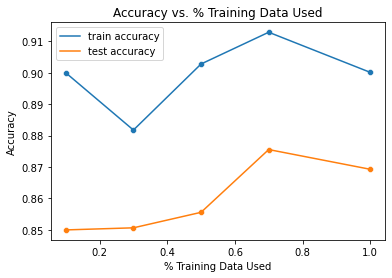

In [10]:
# configurations
config = dict(
    epochs=10,
    classes=10,
    kernels=[256, 128, 128],
    batch_size=64,
    learning_rate=0.001,
    sls = 0.1,
    dataset="Fashion-MNIST",
    architecture="MLP"
)

# Build, train and analyze the model with the pipeline
portions = [0.1, 0.3, 0.5, 0.7, 1]
train_acc_list = []
test_acc_list = []
for sls in portions:
    config['sls'] = sls
    model, tr_acc, te_acc = model_pipeline(config)
    train_acc_list.append(tr_acc)
    test_acc_list.append(te_acc)

# Visualize the results
plt.title("Accuracy vs. % Training Data Used")
plt.xlabel("% Training Data Used")
plt.ylabel("Accuracy")
sns.scatterplot(x=portions, y=train_acc_list)
sns.lineplot(x=portions, y=train_acc_list, label="train accuracy")
sns.scatterplot(x=portions, y=test_acc_list)
sns.lineplot(x=portions, y=test_acc_list, label="test accuracy");

### Model Accuracy vs. Epoches

Train our model at Memory Equivalent Capacity for epoches 1, 10, 20, 30, 50, 80. Can we reach near 100% memorization?

In [12]:
# Assume kernel includes the number of nodes for four layers. 
def compute_mec(kernel, in_features=784):
    layer1 = (in_features + 1) * kernel[0] 
    layer2 = min(kernel[0], (kernel[0] + 1) * kernel[1])
    layer3 = min(kernel[1], (kernel[1] + 1) * kernel[2])
    layer4 = min(kernel[2], (kernel[2] * 1) * 10)
    output = 10 # output layer has 10 bits for 10 nodes 
    return layer1 + layer2 + layer3 + layer4 + output


Training our model at MEC =  201482 



Accuracy of the model on the 6000 images: 74.55%
Accuracy of the model on the 1000 images: 74.2%


train_accuracy,█▁
train_accuracy,0.742


Accuracy of the model on the 6000 images: 88.93333333333334%
Accuracy of the model on the 1000 images: 83.5%


epoch,▁▂▃▄▅▅▆▇█
loss,█▂▃▂▄▃▂▂▁
train_accuracy,█▁
epoch,9
loss,0.30217
train_accuracy,0.835


Accuracy of the model on the 6000 images: 93.11666666666666%
Accuracy of the model on the 1000 images: 84.3%


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇██
loss,█▃▄▃▄▄▃▄▃▁▁▂▁▂▂▂▂▁
train_accuracy,█▁
epoch,19
loss,0.1596
train_accuracy,0.843


Accuracy of the model on the 6000 images: 94.31666666666666%
Accuracy of the model on the 1000 images: 83.5%


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▄▄▄▅▅▄▄▃▂▂▂▂▂▂▂▂▁▃▂▂▁▁▂▂▃▂▁
train_accuracy,█▁
epoch,29
loss,0.05838
train_accuracy,0.835


Accuracy of the model on the 6000 images: 96.86666666666666%
Accuracy of the model on the 1000 images: 84.2%


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▃▅▅▄▃▂▂▂▂▂▂▂▁▃▂▂▁▂▁▃▁▂▂▂▂▁▂▁▂▂▂▁▁▂▁▂▁
train_accuracy,█▁
epoch,49
loss,0.08581
train_accuracy,0.842


Accuracy of the model on the 6000 images: 97.26666666666667%
Accuracy of the model on the 1000 images: 84.1%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▄▅▄▂▂▃▂▂▃▂▂▂▂▂▁▂▁▂▂▁▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▂▂▁
train_accuracy,█▁
epoch,79
loss,0.05974
train_accuracy,0.841


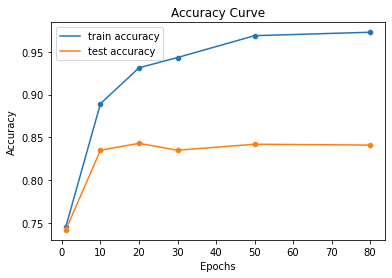

In [13]:
# configurations
config = dict(
    epochs=1,
    classes=10,
    kernels=[256, 128, 128],
    batch_size=64,
    learning_rate=0.001,
    sls = 0.1,
    dataset="Fashion-MNIST",
    architecture="MLP"
)

# Memory Equivalent Capacity
print("\nTraining our model at MEC = ", compute_mec(config['kernels']), "\n")

# Build, train and analyze the model with the pipeline
epoch_list = [1, 10, 20, 30, 50, 80]
train_acc_list = []
test_acc_list = []
for e in epoch_list:
    config['epochs'] = e
    model, tr_acc, te_acc = model_pipeline(config)
    train_acc_list.append(tr_acc)
    test_acc_list.append(te_acc)

# Visualize the results
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
sns.scatterplot(x=epoch_list, y=train_acc_list)
sns.lineplot(x=epoch_list, y=train_acc_list, label="train accuracy")
sns.scatterplot(x=epoch_list, y=test_acc_list)
sns.lineplot(x=epoch_list, y=test_acc_list, label="test accuracy");

### Model Accuracy vs. Model MEC

In this section, we train our machine learner for generalization and plot the capacity / accuracy plot. We vary the `kernels` in `config` to modify the MEC of our model and observe the change in accuracy. The generalization score is also computed. 

Accuracy of the model on the 60000 images: 94.02166666666666%
Accuracy of the model on the 10000 images: 88.28%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,▇▅█▆▄▄▃▂▄▄▅▂▃▂▅▂▂▄▂▃▂▂▂▂▂▂▁▂▁▁▁▂▂▂▂▂▁▂▂▂
train_accuracy,█▁
epoch,49
loss,0.08084
train_accuracy,0.8828


Accuracy of the model on the 60000 images: 93.515%
Accuracy of the model on the 10000 images: 87.62%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▅█▅▄▅▄▃▄▃▅▂▃▂▅▂▂▃▂▃▂▃▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▂▁▃
train_accuracy,█▁
epoch,49
loss,0.06132
train_accuracy,0.8762


Accuracy of the model on the 60000 images: 92.315%
Accuracy of the model on the 10000 images: 86.67%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▆▇▅▄▆▃▃▄▅▅▂▃▁▆▃▃▃▂▂▂▃▂▁▃▂▃▂▃▂▂▃▃▁▃▂▂▂▃▂
train_accuracy,█▁
epoch,49
loss,0.16134
train_accuracy,0.8667


Accuracy of the model on the 60000 images: 90.36333333333333%
Accuracy of the model on the 10000 images: 86.22%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▅▆▄▄▄▄▃▅▅▅▂▃▂▅▂▂▅▂▁▂▄▁▃▃▂▁▄▂▁▂▃▂▁▃▁▂▂▃▃
train_accuracy,█▁
epoch,49
loss,0.20999
train_accuracy,0.8622


Accuracy of the model on the 60000 images: 88.22666666666667%
Accuracy of the model on the 10000 images: 85.02%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▄▆▄▄▇▃▂▄▄▆▃▃▃▅▂▂▆▂▂▂▄▂▃▃▃▃▄▂▂▃▅▃▂▃▁▃▃▄▄
train_accuracy,█▁
epoch,49
loss,0.31014
train_accuracy,0.8502


Accuracy of the model on the 60000 images: 84.04333333333334%
Accuracy of the model on the 10000 images: 81.91%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▅▄▄▂▅▃▂▃▃▃▂▂▃▄▂▃▃▂▂▂▂▂▂▂▃▂▂▁▃▂▃▂▁▂▁▃▂▃▂
train_accuracy,█▁
epoch,49
loss,0.42818
train_accuracy,0.8191


Accuracy of the model on the 60000 images: 77.51833333333333%
Accuracy of the model on the 10000 images: 76.1%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▄▃▃▂▃▃▂▃▃▃▂▂▂▃▂▂▃▂▁▂▂▂▂▂▃▂▃▂▂▂▂▁▂▂▁▂▂▃▂
train_accuracy,█▁
epoch,49
loss,0.52299
train_accuracy,0.761


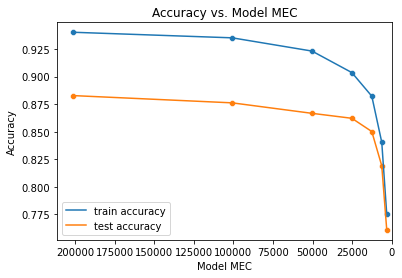

In [14]:
# configurations
config = dict(
    epochs=50,
    classes=10,
    kernels=[256, 128, 128],
    batch_size=64,
    learning_rate=0.001,
    sls = 1,
    dataset="Fashion-MNIST",
    architecture="MLP"
)

# Build, train and analyze the model with the pipeline
k_list = [
    [256, 128, 128],
    [128, 64, 64],
    [64, 32, 32],
    [32, 16, 16],
    [16, 8, 8],
    [8, 4, 4],
    [4, 4, 2]
]
mec_list = [compute_mec(k) for k in k_list] # computes mec for each model
train_acc_list = []
test_acc_list = []
for k in k_list:
    config['kernels'] = k
    model, tr_acc, te_acc = model_pipeline(config)
    train_acc_list.append(tr_acc)
    test_acc_list.append(te_acc)

# Visualize the results
plt.title("Accuracy vs. Model MEC")
plt.xlabel("Model MEC")
plt.ylabel("Accuracy")
sns.scatterplot(x=mec_list, y=train_acc_list)
sns.lineplot(x=mec_list, y=train_acc_list, label="train accuracy")
sns.scatterplot(x=mec_list, y=test_acc_list)
sns.lineplot(x=mec_list, y=test_acc_list, label="test accuracy");
plt.xlim(max(mec_list) + 10000, 0); # invert the x-axis

In [15]:
num_nodes = k_list.copy()
[n.append(10) for n in num_nodes] # include the last output layer
table = pd.DataFrame({
    "# Neurons in Four Layers": num_nodes,
    "Model MEC (bits)": mec_list, 
    "Train Accuracy": train_acc_list, 
    "Test Accuracy": test_acc_list
})
table['Generalization'] = table['Train Accuracy'] * 60000 / table['Model MEC (bits)']
table

,# Neurons in Four Layers,Model MEC (bits),Train Accuracy,Test Accuracy,Generalization
0,"[256, 128, 128, 10]",201482,0.940217,0.8828,0.279990
1,"[128, 64, 64, 10]",100746,0.935150,0.8762,0.556935
2,"[64, 32, 32, 10]",50378,0.923150,0.8667,1.099468
3,"[32, 16, 16, 10]",25194,0.903633,0.8622,2.152020
4,"[16, 8, 8, 10]",12602,0.882267,0.8502,4.200603
5,"[8, 4, 4, 10]",6306,0.840433,0.8191,7.996511
6,"[4, 4, 2, 10]",3160,0.775183,0.7610,14.718671
